In [24]:
# imports
import anndata
import numpy
%matplotlib inline
import novosparc

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import zscore

# Gaussian mixture model
from sklearn.mixture import GaussianMixture

# 3d plot
from mpl_toolkits import mplot3d

import random
random.seed(0)

In [2]:
sdge = np.genfromtxt("droso_sdge.csv", delimiter=",")
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = '../../novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
atlas_dir = '../../novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values
locations = locations_apriori

atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

/tmp/ipykernel_6401/2197252676.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


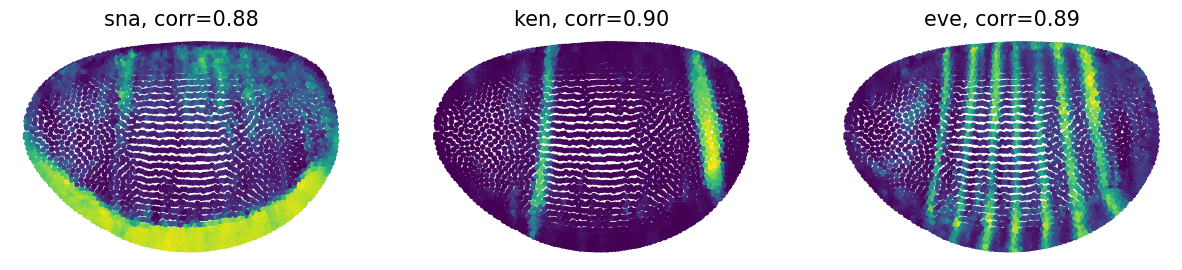

<Figure size 432x288 with 0 Axes>

In [4]:
# test original reconstructed expression of individual genes
pl_genes = ['sna', 'ken', 'eve']
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]
novosparc.pl.embedding(dataset_reconst, pl_genes, title=title)

## Make a minimal Test set with the three important genes

In [5]:
sdge_test_cols = []
for i, gene in enumerate(pl_genes):
    if gene in dataset_reconst.var_names:
        sdge_test_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1, 1))
sdge_test = np.concatenate(sdge_test_cols, axis=1)

## Get 2d locations per gene

In [6]:
sna_locations = np.asarray(dataset_reconst[:, "sna"].obsm["spatial"])
# numpy.savetxt("droso_sna_2d_locations.csv", sna_locations, delimiter=",")

### single gene example

In [70]:
# only gene sna
sdge_small = sdge_test[:,0].reshape(-1,1)
# normalize using zscore
sdge_small_normed_zscore = zscore(sdge_small)
sdge_small_normed_zscore[:5]

array([[-0.38856974],
       [ 0.02192618],
       [-0.3191301 ],
       [-0.14921233],
       [-0.2102963 ]], dtype=float32)

## make 3d matrix

In [71]:
sna_3d = np.concatenate((sna_locations,
                        sdge_small_normed_zscore), axis=1)

sna_3d[:5]

array([[-1.94040000e+02,  3.02000000e+01, -3.88569742e-01],
       [-2.03320000e+02,  2.00800000e+01,  2.19261833e-02],
       [-2.00250000e+02,  2.39300000e+01, -3.19130093e-01],
       [-2.05880000e+02,  1.48200000e+01, -1.49212331e-01],
       [-1.93170000e+02,  2.96700000e+01, -2.10296303e-01]])

## some plotting

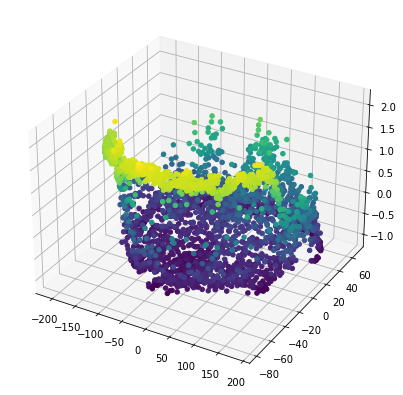

In [72]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
ax.scatter(sna_3d[:,0], sna_3d[:,1], sna_3d[:,2], alpha = 1, c=sna_3d[:,2], cmap="viridis")

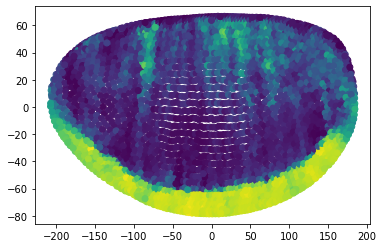

In [73]:
plt.scatter(sna_3d[:,0], sna_3d[:,1], alpha = 1, c=sna_3d[:,2], cmap="viridis")

In [124]:
gmm = GaussianMixture(n_components=2, random_state=42).fit(sna_3d)

In [125]:
help(GaussianMixture)

Help on class GaussianMixture in module sklearn.mixture._gaussian_mixture:

class GaussianMixture(sklearn.mixture._base.BaseMixture)
 |  GaussianMixture(n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)
 |  
 |  Gaussian Mixture.
 |  
 |  Representation of a Gaussian mixture model probability distribution.
 |  This class allows to estimate the parameters of a Gaussian mixture
 |  distribution.
 |  
 |  Read more in the :ref:`User Guide <gmm>`.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  n_components : int, default=1
 |      The number of mixture components.
 |  
 |  covariance_type : {'full', 'tied', 'diag', 'spherical'}, default='full'
 |      String describing the type of covariance parameters to use.
 |      Must be one of:
 |  
 |      - 'full': each component has 

In [126]:
gmm.means_

array([[-16.40366275,   7.35256336,  -0.7038476 ],
       [ 19.64532508,  -8.62991084,   0.84760705]])

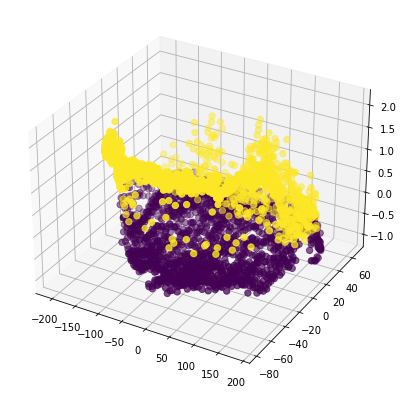

In [134]:
fig = plt.figure(figsize = (10, 7))
labels = gmm.predict(sna_3d)
ax = plt.axes(projection='3d')
ax.scatter(sna_3d[:, 0], sna_3d[:, 1], sna_3d[:, 2], c=labels, s=40, cmap='viridis');

In [136]:
sna_filtered_no1 = sna_3d * labels.reshape(-1,1)

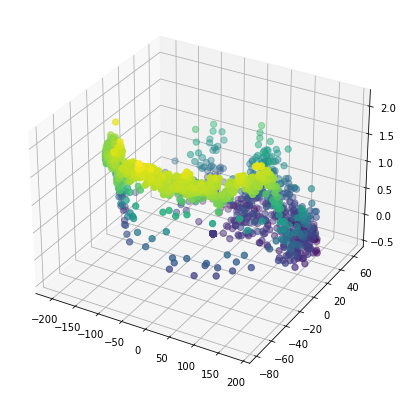

In [137]:
fig = plt.figure(figsize = (10, 7))
labels = gmm.predict(sna_3d)
ax = plt.axes(projection='3d')
ax.scatter(sna_filtered_no1[:, 0], sna_filtered_no1[:, 1], sna_filtered_no1[:, 2], c=sna_filtered_no1[:, 2], s=40, cmap='viridis');

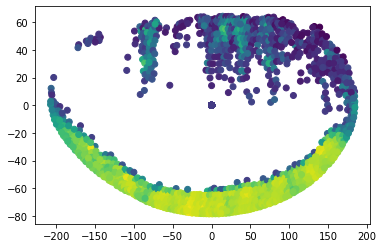

In [148]:
plt.scatter(sna_filtered_no1[:,0], sna_filtered_no1[:,1], alpha = 1, c=sna_filtered_no1[:,2], cmap="viridis")

In [215]:
sna_filtered_no1 = sna_filtered_no1[~np.all(sna_filtered_no1 == 0, axis=1)]

(1280, 3)
[[ 67.6525363   25.67199172]
 [-35.57414669 -58.02566907]]


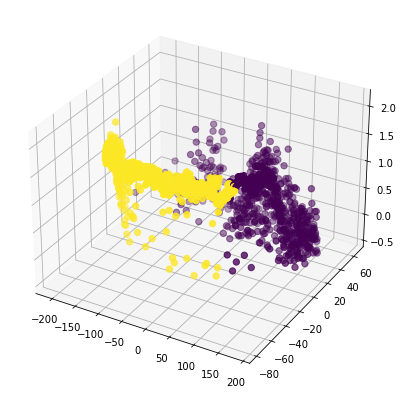

In [243]:
print(sna_filtered_no1.shape)
gmm2 = GaussianMixture(n_components=2, random_state=42,
                       covariance_type='full',
                       init_params="kmeans").fit(sna_filtered_no1[:,0:2])
print(gmm2.means_)

# plot 3d
fig = plt.figure(figsize = (10, 7))
labels2 = gmm2.predict(sna_filtered_no1[:,0:2])
ax = plt.axes(projection='3d')
ax.scatter(sna_filtered_no1[:, 0], sna_filtered_no1[:, 1], sna_filtered_no1[:, 2], c=labels2, s=40, cmap='viridis');

# filter after labels
sna_filtered_no2 = sna_filtered_no1 * labels2.reshape(-1,1)

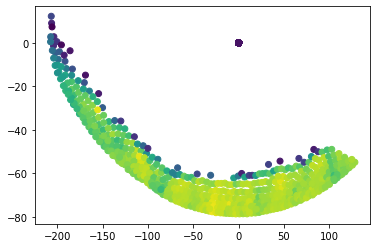

In [244]:
# plot 2d
plt.scatter(sna_filtered_no2[:,0], sna_filtered_no2[:,1], alpha = 1, c=sna_filtered_no2[:,2], cmap="viridis")

(1280, 3)
[[0.24681121]
 [1.75929795]]


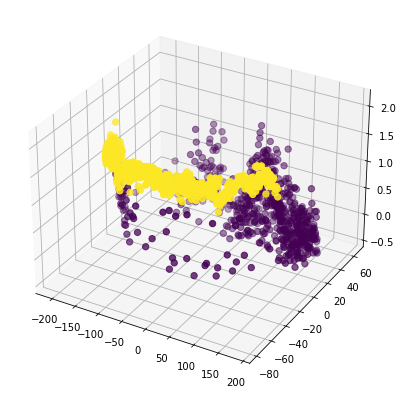

In [227]:
print(sna_filtered_no1.shape)
gmm3 = GaussianMixture(n_components=2, random_state=42,
                       covariance_type='full',
                       init_params="kmeans").fit(sna_filtered_no1[:,2].reshape(-1,1))
print(gmm3.means_)
fig = plt.figure(figsize = (10, 7))
labels3 = gmm3.predict(sna_filtered_no1[:,2].reshape(-1,1))
ax = plt.axes(projection='3d')
ax.scatter(sna_filtered_no1[:, 0], sna_filtered_no1[:, 1], sna_filtered_no1[:, 2], c=labels2, s=40, cmap='viridis');

# filter
sna_filtered_no3 = sna_filtered_no1 * labels3.reshape(-1, 1)

(-80.0, 0.0)

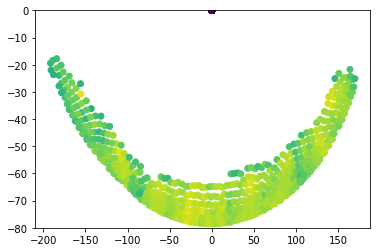

In [236]:
#plot 2d
plt.scatter(sna_filtered_no3[:, 0], sna_filtered_no3[:, 1], alpha=1, c=sna_filtered_no3[:, 2], cmap="viridis")
plt.ylim(-80,0)

In [235]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)
    A scatter plot of *y* vs. *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : float or array-like, shape (n, )
        The data positions.
    
    s : float or array-like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : array-like or list of colors or color, optional
        The marker colors. Possible values:
    
        - A scalar or sequence of n numbers to be mapped to colors using
          *cmap* and *norm*.
        - A 2D array in which the rows are RGB or RGBA.
        - A sequence of colors of length n.
        - A single color format string.
    
        Note that *c* should not be a single numeric RGB or RGBA sequence
    

In [240]:
gmm3.covariances_[0] = gmm3.covariances_[0]+2

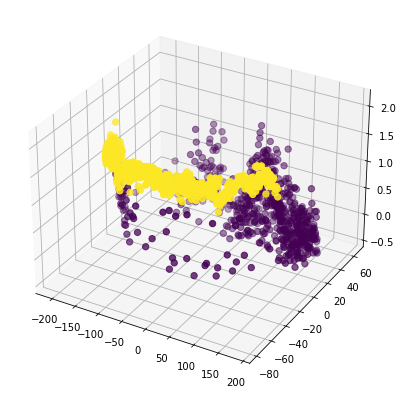

In [241]:
fig = plt.figure(figsize = (10, 7))
labels3 = gmm3.predict(sna_filtered_no1[:,2].reshape(-1,1))
ax = plt.axes(projection='3d')
ax.scatter(sna_filtered_no1[:, 0], sna_filtered_no1[:, 1], sna_filtered_no1[:, 2], c=labels2, s=40, cmap='viridis');

# filter
sna_filtered_no3 = sna_filtered_no1 * labels3.reshape(-1, 1)

In [242]:
gmm3.covariances_[0]

array([[2.48319823]])